<a href="https://colab.research.google.com/github/Varchala/Secure_Private_AI/blob/main/poisoning_varchala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisoning

In this exercise we will be exploring data poisoning. Specifically backdoor poisoning. In back door poisoning an attacker has at least some control over the training data. Their goal is to place a marker in the data so that later at test time the system behaves in a certain way when it finds the marker.

In our case the desired behaviour is to predict a specific class that the attacker chooses at attack time.

The attack consists of the following steps:

1.   Create a marker/pattern
2.   Embed the marker in the training data
3.   Label all the marked data with the desired label

Below you can find a code stub that you can use need to expand to create poisoned data and train a model on that data. Afterwards you need to perform some evaluation on the data. Design your experiments to answer the following questions:

1.   How large does a marker need to be effective?
2.   Does the opacity of the marker matter?
3.   Does the "design" of the marker have any impact on success rate?
4.   Are there good or bad marker placements? If so where are they? Can you think of a way to determine good placement?
5.   Does the marker always need to be in the same place?
6.   Do you need access to all classes during training? How many classes do you need access to?
7.   Does the backdoor attack impact the model's performance on clean data?
8.   Is the marker on its own effective? Do you need to modify valid instances? Think about training and test time?


# TIP

Change the runtime to GPU accelerated. Otherwise, you will be here for a while.

To do this:

1.   Select `Runtime` from the menu at the top
2.   Click `Change Runtime type`
3.   Under `Hardware accelerator` choose `GPU`
4.   Hit `Save` and if it is asks you to reconnect do so



In [ ]:
!pip install tensorflow-gpu==1.15.2 keras==2.2.3


In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1


demo

![example](https://i2.wp.com/bdtechtalks.com/wp-content/uploads/2020/10/trojannet-stop-sign.jpg)

Pipeline

![pipeline](https://blog-assets.f-secure.com/wp-content/uploads/2021/04/13152604/data_poisoning_in_action_fig1-1536x463.png)

We add the poisoned data to retrain the model.

Let's first load the library

In [63]:
%tensorflow_version 1.x
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

Define some helper functions for visualization and format-convert.

In [46]:
# helper functions
def show_image( img ):
  plt.imshow( img.reshape( int( np.sqrt( img.size ) ), int( np.sqrt( img.size ) ) ), cmap="gray_r" )
  plt.axis( 'off' )
  plt.show( )


def convert_to_keras_image_format( x_train, x_test ):
    if keras.backend.image_data_format( ) == 'channels_first':
        x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
        x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    else:
        x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
        x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )

    return x_train, x_test

Load the data and normalize the data

In [74]:
# load data and quantize
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype( float ) / 255.
x_test = x_test.astype( float ) / 255.

1. create the marker/pattern

In [8]:
import torch

poisoning marker:


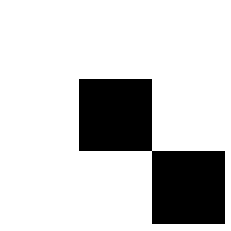

In [75]:
# create a poisoning pattern
# be sure to make it square. the code the relies on it being square
# a = torch.randn(4)

# pattern=torch.square(a)
pattern = np.zeros((3, 3))
pattern[0, 0] = 0
pattern[1, 1] = 1
pattern[2, 2] = 1
print( 'poisoning marker:' )

show_image( pattern )


add the pattern to one image as a demo

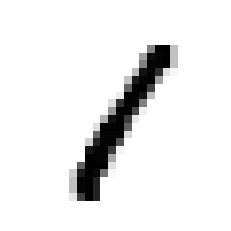

one image


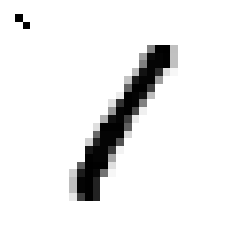

In [76]:
# pick one image
# test_img = X_test[ind, 0, :, :].cpu().detach().numpy()
#   test_img *= 255.0
#   test_img += pattern
#   test_img = torch.tensor(test_img)
#   test_img /= 255.0
#   test_img = test_img.unsqueeze(0)
#   test_img = test_img.to(device)

img = np.copy(x_train[3])
show_image( img )
img[0:3,0:3] =pattern
print( 'one image' )


# add poisoning pattern

show_image( img )

2. Embed the marker in the training data (maybe a subset)

show one image


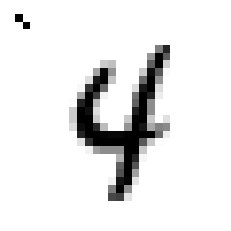

In [77]:
# pick a random subset images
# sub_im = x_train[:100]
num_imgs=x_train.shape[0]
num_poi=100
idx=np.arange(num_imgs,dtype=np.int)
np.random.shuffle(idx)
poisoned_images=np.copy(x_train[idx[:num_poi]])
poisoned_images[:,0:3,0:3]=pattern
# place the marker in the images


print("show one image")
show_image( poisoned_images[ 0] )


3. Label all the marked data with the desired label
4.  add to the training dataset

In [78]:
x_train.shape, poisoned_images.shape

((60000, 28, 28), (100, 28, 28))

In [79]:
# pick a target label and create labels for the poisoned images
tar_label=7
pois_labels=np.ones(num_poi)*tar_label
# add the poisoned data to the training data
x_train=np.concatenate((x_train,poisoned_images),axis=0)
y_train = np.concatenate((y_train,pois_labels),axis=0)

5. train with poisoned data

In [80]:
# transform data to the correct format
x_train, x_test = convert_to_keras_image_format( x_train, x_test )
y_train = keras.utils.to_categorical( y_train )
y_test = keras.utils.to_categorical( y_test )

model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:] ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

model.fit( x_train, y_train, epochs=3 )

print("evaluate on clean data")
model.evaluate( x_test, y_test )
  

Epoch 1/3
60100/60100 [==============================] - 17s 281us/step - loss: 0.1355 - accuracy: 0.9600
Epoch 2/3
60100/60100 [==============================] - 16s 272us/step - loss: 0.0413 - accuracy: 0.9871
Epoch 3/3
60100/60100 [==============================] - 16s 268us/step - loss: 0.0214 - accuracy: 0.9931
evaluate on clean data
10000/10000 [==============================] - 1s 102us/step


[0.05735858500120084, 0.9818000197410583]

the whole pipeline  contains all steps above.

In [72]:
# load data and quantize
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype( float ) / 255.
x_test = x_test.astype( float ) / 255.

# create a poisoning pattern
# be sure to make it square. the code the relies on it being square

print( 'poisoning marker:' )

# pick some image
print( 'some image' )

# add poisoning pattern

# pick a random subset images


# place the marker in the images

# pick a target label and create labels for the poisoned images

# add the poisoned data to the training data

# transform data to the correct format
x_train, x_test = convert_to_keras_image_format( x_train, x_test )
y_train = keras.utils.to_categorical( y_train )
y_test = keras.utils.to_categorical( y_test )

model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:] ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

model.fit( x_train, y_train, epochs=3 )

model.evaluate( x_test, y_test )

poisoning marker:
some image
Epoch 1/3
60000/60000 [==============================] - 17s 286us/step - loss: 0.1444 - accuracy: 0.9564
Epoch 2/3
60000/60000 [==============================] - 16s 269us/step - loss: 0.0429 - accuracy: 0.9867
Epoch 3/3
10000/10000 [==============================] - 1s 104us/step


[0.057109006787394175, 0.982699990272522]

Verify if the model is poisoned and can be attacked by the data.

test image shape: (28, 28, 1)
test image:


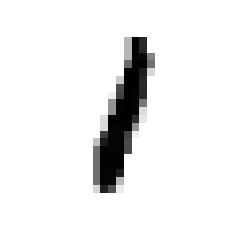

prediction for the test image:
1


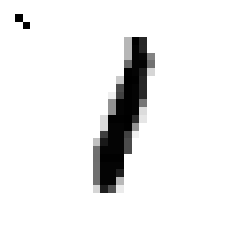

prediction for the test image:
7


In [92]:
# take an image from the test data
# idx = np.copy(x_test[0])
idx=455
test_image = np.copy( x_test[ idx ] )
print( 'test image shape:', test_image.shape )
print( 'test image:' )
show_image( test_image )

# get the models' prediction
test_image=np.expand_dims(test_image, axis=0)
pred=np.argmax(model.predict(test_image))
print( 'prediction for the test image:' )
print( pred )
test_image=test_image.reshape((28,28))
test_image[0:3,0:3]=pattern
show_image(test_image)
test_image=test_image.reshape((1,28,28,1))
pred=np.argmax(model.predict(test_image))
print( 'prediction for the test image:' )
print( pred )
# add the marker


# prediction with the marker


# add the marker to the entire test data

more questions

random image:


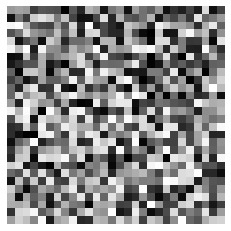

prediction for random image: 7
random image with marker:


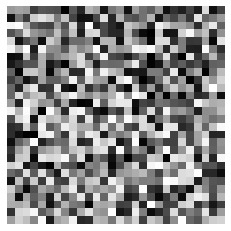

prediction for random image with marker: 7


In [96]:
# test how markers behave on random data

# 1. generate an image with shape (28, 28)
rnd_img = np.random.sample((28,28))
print( 'random image:' )
show_image( rnd_img )

# 2. prediction
pred=np.argmax(model.predict(rnd_img.reshape((1,28,28,1))))
print( 'prediction for random image:', pred )

# 4. add the pattern to the random image, what will happen?
# rnd_img[]
print( 'random image with marker:' )
show_image( rnd_img )
print( 'prediction for random image with marker:', pred )


# Note: you can run it several times to check the results.

In [ ]:
# what about random marker position?

# 1. generate the random position (x, y)

# 2. select one test image

# 3. get the original prediction on the image

# 4. add the marker to the image

# 5. prediction with the marker


# Note: you can run it several times.


More thinking


1.   How large does a marker need to be effective?
2.   Does the opacity of the marker matter?
3.   Does the "design" of the marker have any impact on success rate?
4.   Are there good or bad marker placements? If so where are they? Can you think of a way to determine good placement?
5.   Does the marker always need to be in the same place?
6.   Do you need access to all classes during training? How many classes do you need access to?
7.   Does the backdoor attack impact the model's performance on clean data?
8.   Is the marker on its own effective? Do you need to modify valid instances? Think about training and test time?


Let's poison attempts with random marker positions at training time

poisoning marker:
ratio of poisoned images 0.0016666666666666668
(100, 28, 28) (60000, 28, 28)
show one image


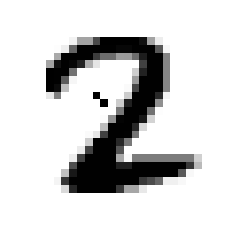

Epoch 1/3
60100/60100 [==============================] - 18s 292us/step - loss: 0.1458 - accuracy: 0.9583
Epoch 2/3
60100/60100 [==============================] - 17s 284us/step - loss: 0.0473 - accuracy: 0.9853
Epoch 3/3
10000/10000 [==============================] - 1s 109us/step


[0.05080565011515282, 0.984000027179718]

In [103]:
# load data and quantize
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype( float ) / 255.
x_test = x_test.astype( float ) / 255.

# create a poisoning pattern
# be sure to make it square. the code the relies on it being square
# or you can use the previous marker
print( 'poisoning marker:' )

# pick a random subset images
num_poisoned_images =  100
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )


# ***Difference***
# 1. random select a position (x, y)
x, y = 205,209
# 2. place the marker in the images random parts of the image
# pick a random subset images
# sub_im = x_train[:100]
num_imgs=x_train.shape[0]
num_poi=100
idx=np.arange(num_imgs,dtype=np.int)
np.random.shuffle(idx)
poisoned_images=np.copy(x_train[idx[:num_poi]])
print(poisoned_images.shape,x_train.shape)
poisoned_images[:,10:13,10:13]=pattern
# place the marker in the images


print("show one image")
show_image( poisoned_images[ 0] )


# pick a target label and create labels for the poisoned images

# add the poisoned data to the training data

# transform data to the correct format
tar_label=7
pois_labels=np.ones(num_poi)*tar_label
# add the poisoned data to the training data
x_train=np.concatenate((x_train,poisoned_images),axis=0)
y_train = np.concatenate((y_train,pois_labels),axis=0)
x_train, x_test = convert_to_keras_image_format( x_train, x_test )
y_train = keras.utils.to_categorical( y_train )
y_test = keras.utils.to_categorical( y_test )

model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:] ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

model.fit( x_train, y_train, epochs=3 )

model.evaluate( x_test, y_test )

Verify if the model is poisoned and can be attacked by the data.

test image shape: (28, 28, 1)
test image:


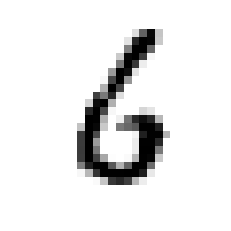

prediction for the test image:
6


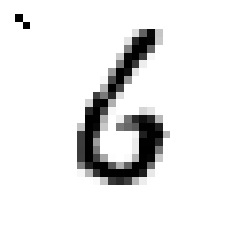

prediction for the test image:
6


In [110]:
# take an image from the test data
idx = 50
test_image = np.copy( x_test[ idx ] )
print( 'test image shape:', test_image.shape )
print( 'test image:' )
show_image( test_image )

# get the models' prediction
print( 'prediction for the test image:' )
print( np.argmax(model.predict(test_image.reshape(1,28,28,1))) )


# add the marker
test_image[0:3,0:3,:]=pattern.reshape((3,3,1))
show_image( test_image )
print( 'prediction for the test image:' )
print( np.argmax(model.predict(test_image.reshape(1,28,28,1))) )

# prediction with the marker


# add the marker to the entire test data

more questions

In [ ]:
# test how markers behave on random data

# 1. generate an image with shape (28, 28)
rnd_img = ???
print( 'random image:' )
show_image( rnd_img )

# 2. prediction
print( 'prediction for random image:', ??? )

# 4. add the pattern to the random image, what will happen?
???
print( 'random image with marker:' )
show_image( rnd_img )
print( 'prediction for random image with marker:', ??? )


# Note: you can run it several times to check the results.

In [ ]:
# what about random marker position?

# 1. generate the random position (x, y)

# 2. select one test image

# 3. get the original prediction on the image

# 4. add the marker to the image

# 5. prediction with the marker


# Note: you can run it several times.


For `art`, please refer to
[official link](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/poisoning_defense_neural_cleanse.ipynb)

![image](https://raw.githubusercontent.com/Trusted-AI/adversarial-robustness-toolbox/564f46f99b3cb0406fe3570919b8e71a4c5bba9d/utils/data/images/zero_to_one.png)